<a href="https://colab.research.google.com/github/Shiyasalloor/Deep_Learning_Lab/blob/main/GAN_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def real_data_target(size):
    data = Variable(torch.ones(size, 1)).to(device)
    return data

def fake_data_target(size):
    data = Variable(torch.zeros(size, 1)).to(device)
    return data

In [4]:
def imgs_to_vec(imgs, img_size=28):
    return imgs.view(imgs.size(0), img_size * img_size)

def vec_to_imgs(vec):
    return vec.view(vec.size(0), 1, 28, 28)

def noise(size, batch_size=128):
    n = Variable(torch.randn(size, batch_size))
    return n

In [5]:
log_data = []

def log(e, E, b, B, de, ge):
    row = {
        'epoch': e, 'epochs': E,
        'batch': b, 'batches': B,
        'derror': de, 'gerror': ge,
    }

def display_logs(e, E, b, B, de, ge, dr, df, batch_size=128):
    print(f"Epoch {e+1}/{E} ({(e/E)*100:.1f}%):"
          f" [{b*batch_size}/{B*batch_size}] ({(b/B)*100:.1f}%)"
          f" D Error: {de:.4f} G Error: {ge:.4f}")

In [6]:
def display_images(imgs):
    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8,8))
    count = 0
    for y in range(4):
        for x in range(4):
            img = imgs[count].view(28, 28)
            axs[y][x].imshow(img, cmap="gray")
            count += 1
    plt.show()

In [7]:
def mnist_data():
    compose = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])])
    out_dir = '/kaggle/working/mnist/'
    return datasets.MNIST(root=out_dir, train=True,
                          transform=compose, download=True)

data = mnist_data()

data_loader = DataLoader(data, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.81MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.06MB/s]


In [8]:
class DiscriminatorNet(nn.Module):
    """ 3 hidden layer discriminative nn. """
    def __init__(self, n_out=1, img_size=28):
        super(DiscriminatorNet, self).__init__()

        self.hidden0 = nn.Sequential(
            nn.Linear(img_size * img_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        self.out = nn.Sequential(
            nn.Linear(256, n_out),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [9]:
class GeneratorNet(nn.Module):
    """ 3 hidden layer generative nn. """
    def __init__(self, batch_size=128, img_size=28):
        super(GeneratorNet, self).__init__()

        self.hidden0 = nn.Sequential(
            nn.Linear(batch_size, 256),
            nn.LeakyReLU(0.2),
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
        )
        self.out = nn.Sequential(
            nn.Linear(1024, img_size * img_size),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [10]:
discriminator = DiscriminatorNet().to(device)
generator = GeneratorNet().to(device)

In [16]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

loss = nn.BCELoss()
EPOCHS = 20

In [12]:
def train_discriminator(dmodel, optimizer, loss_func, real_data, fake_data):
    optimizer.zero_grad()
    # Train on real data
    pred_real = dmodel(real_data)
    error_real = loss_func(pred_real, real_data_target(real_data.size(0)))
    error_real.backward()
    # Train on fake data
    pred_fake = dmodel(fake_data)
    error_fake = loss_func(pred_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    # Update weights
    optimizer.step()
    # Return error
    return error_real + error_fake, pred_real, pred_fake

In [13]:
def train_generator(dmodel, optimizer, loss_func, fake_data):
    optimizer.zero_grad()
    pred = dmodel(fake_data)
    error = loss_func(pred, real_data_target(pred.size(0)))
    error.backward()
    optimizer.step()
    return error

In [14]:
NUM_BATCHES = len(data_loader)
DISPLAY_EVERY = 1000

num_samples = 16
test_noise = noise(num_samples)
test_noise

tensor([[-1.2005,  0.4564, -0.8007,  ..., -0.4135, -1.7103, -1.5463],
        [-1.4658, -0.5758,  0.5421,  ..., -0.3441, -1.2635, -0.4567],
        [-0.4890,  0.4086, -1.0107,  ..., -0.7456,  0.8814, -0.2191],
        ...,
        [-0.1808,  0.7788, -0.9828,  ...,  1.3514, -0.1373,  0.8170],
        [-0.1266,  1.1208,  0.1091,  ...,  1.1810, -0.3438, -0.0634],
        [ 0.1954,  0.7884, -1.4098,  ...,  0.2904,  1.4409,  0.0565]])

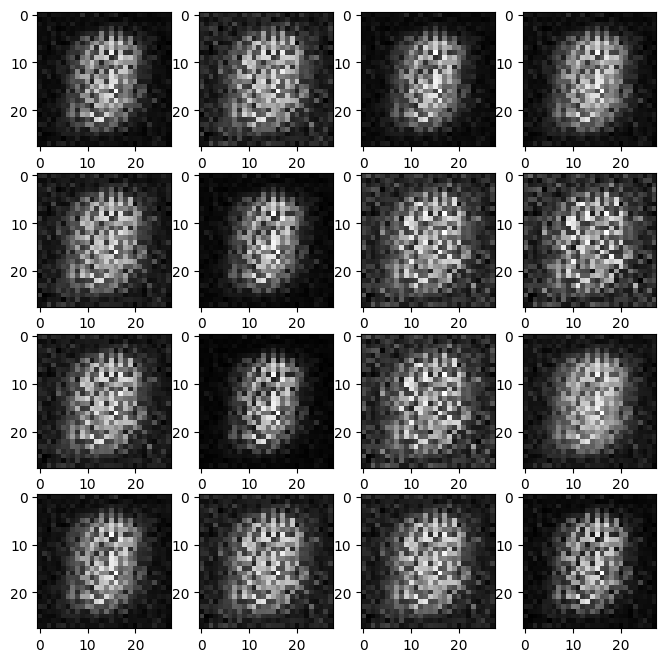

Epoch 1/20 (0.0%): [0/60032] (0.0%) D Error: 1.5038 G Error: 1.6306


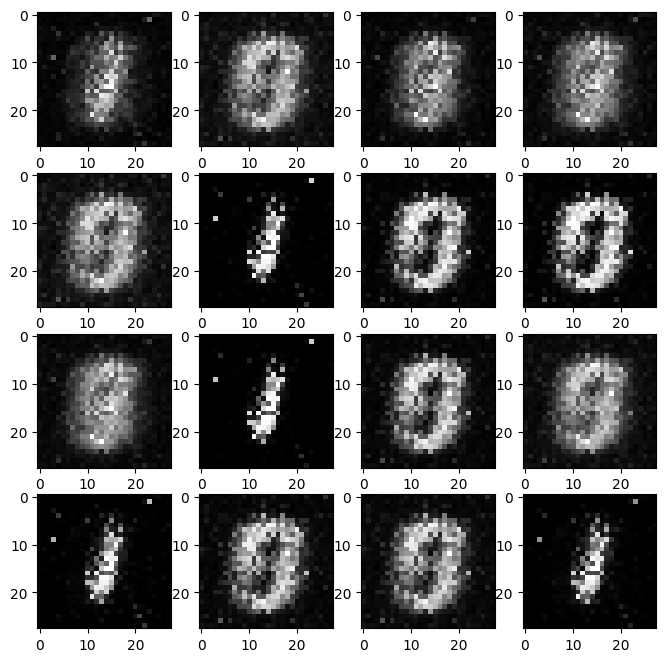

Epoch 2/20 (5.0%): [0/60032] (0.0%) D Error: 1.0113 G Error: 1.7569


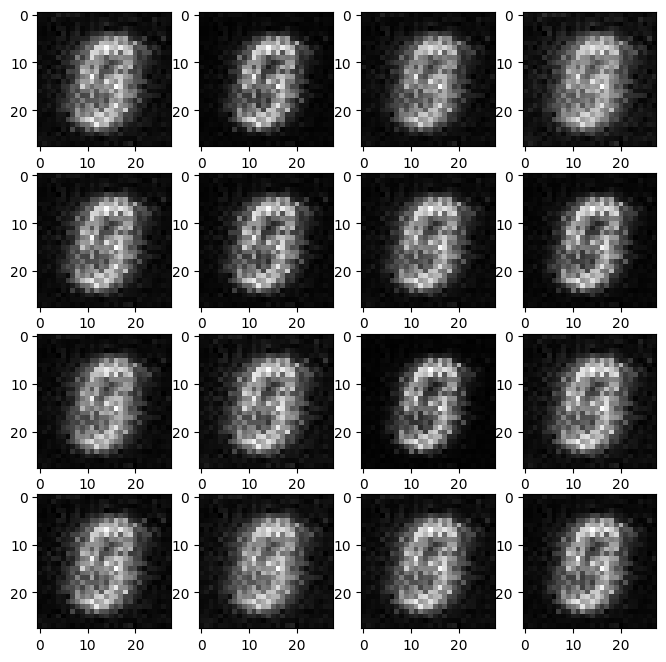

Epoch 3/20 (10.0%): [0/60032] (0.0%) D Error: 0.5309 G Error: 3.1526


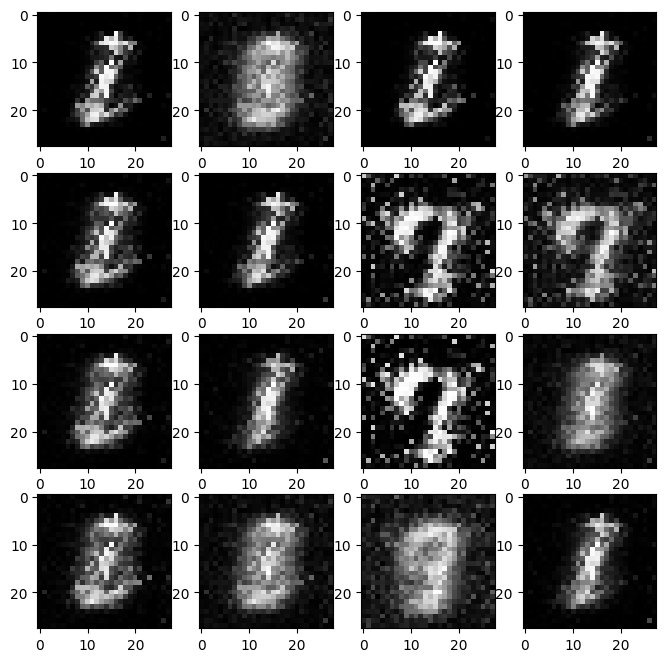

Epoch 4/20 (15.0%): [0/60032] (0.0%) D Error: 0.8672 G Error: 4.4219


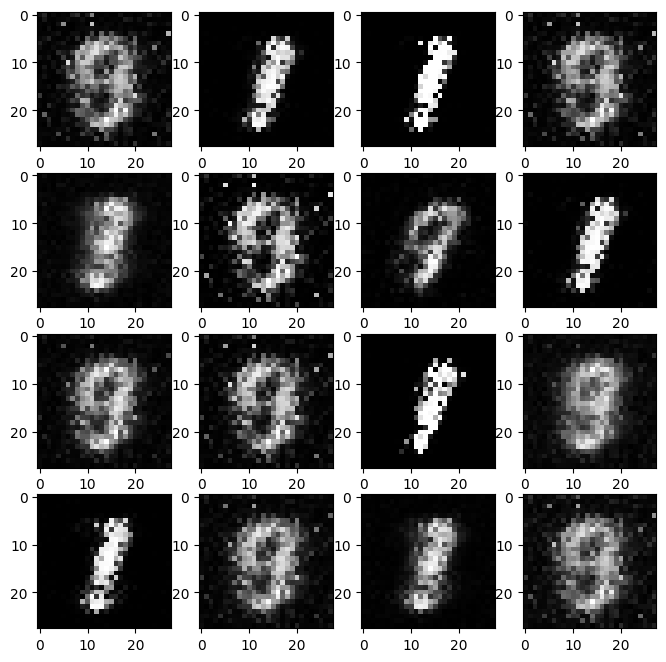

Epoch 5/20 (20.0%): [0/60032] (0.0%) D Error: 0.3513 G Error: 4.5820


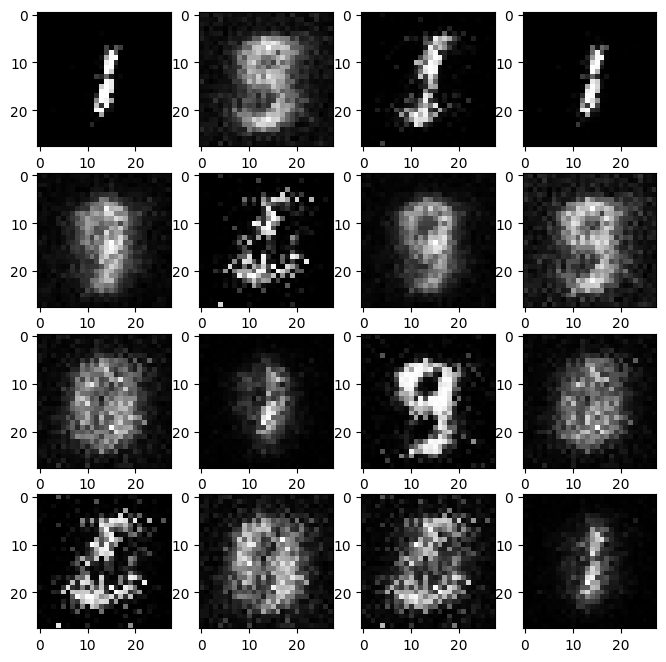

Epoch 6/20 (25.0%): [0/60032] (0.0%) D Error: 0.4317 G Error: 3.4768


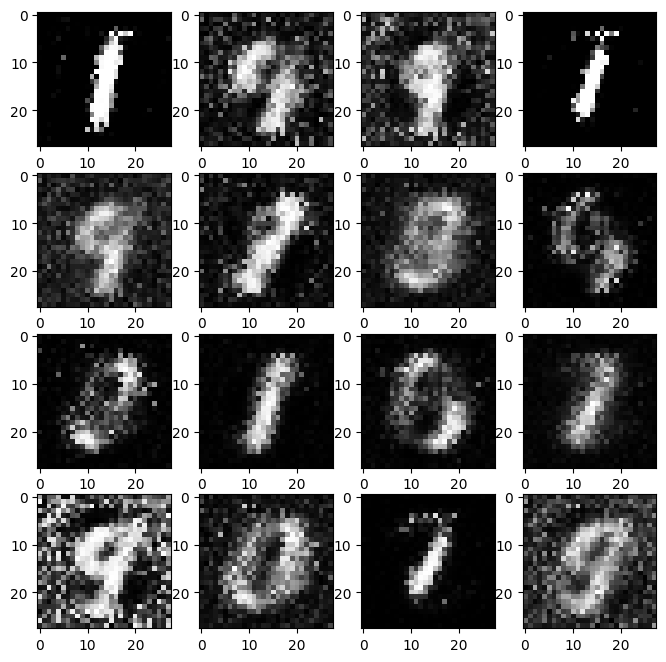

Epoch 7/20 (30.0%): [0/60032] (0.0%) D Error: 0.3779 G Error: 2.1329


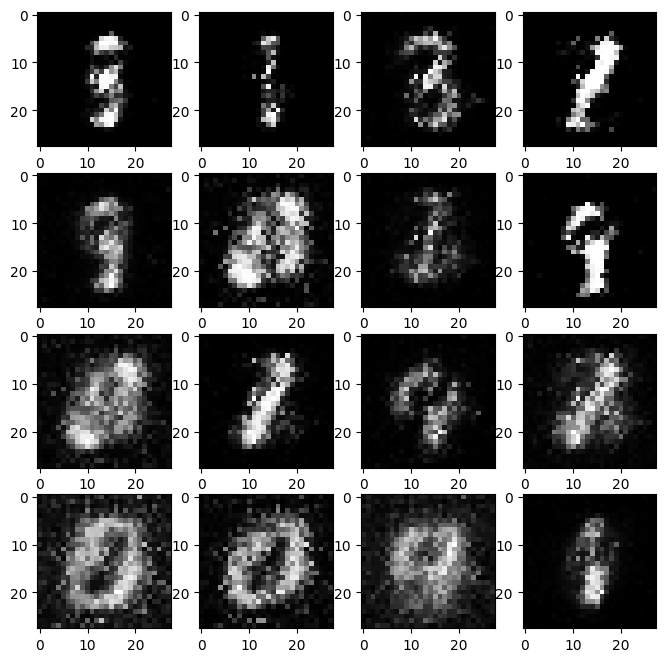

Epoch 8/20 (35.0%): [0/60032] (0.0%) D Error: 0.6953 G Error: 2.4912


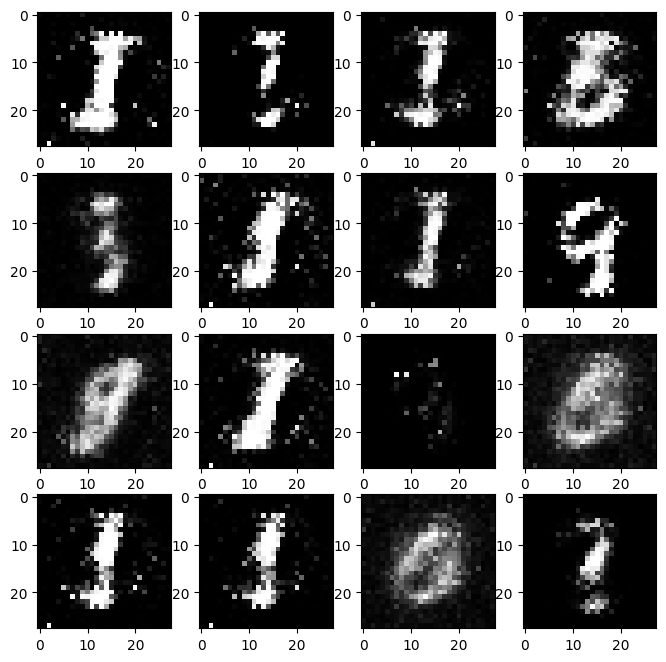

Epoch 9/20 (40.0%): [0/60032] (0.0%) D Error: 0.5151 G Error: 2.7755


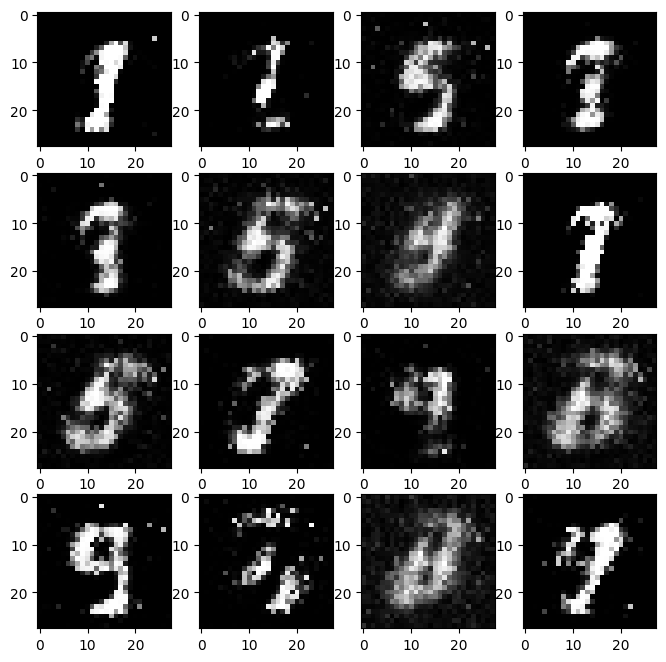

Epoch 10/20 (45.0%): [0/60032] (0.0%) D Error: 0.6384 G Error: 2.2489


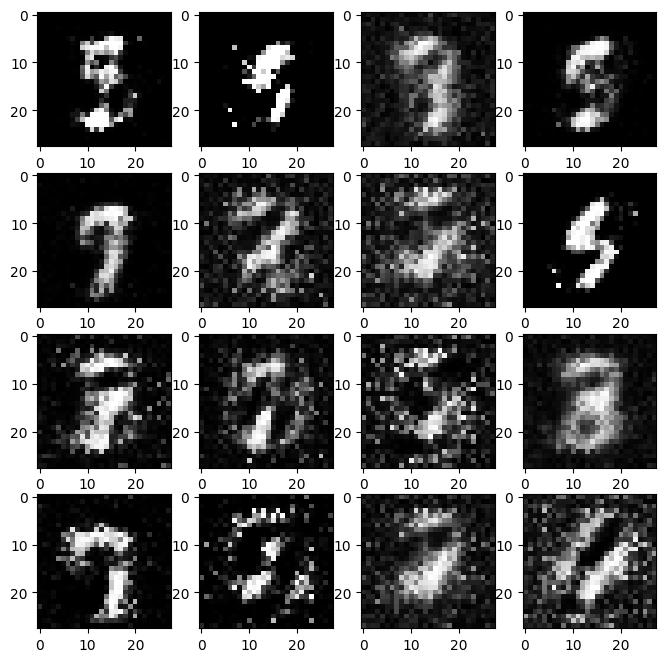

Epoch 11/20 (50.0%): [0/60032] (0.0%) D Error: 0.6384 G Error: 2.4065


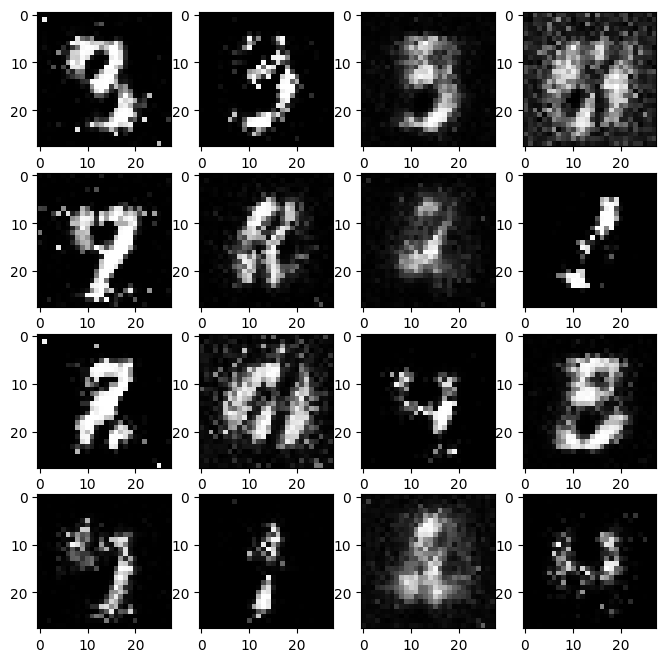

Epoch 12/20 (55.0%): [0/60032] (0.0%) D Error: 0.6615 G Error: 2.0711


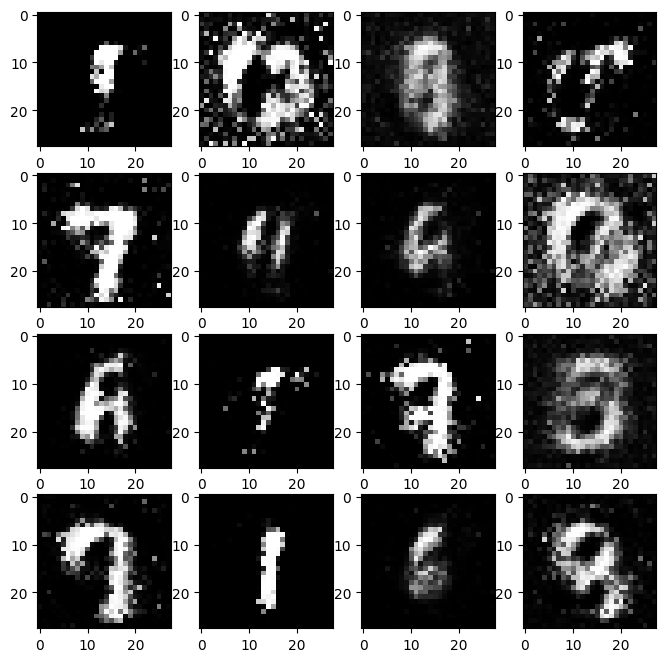

Epoch 13/20 (60.0%): [0/60032] (0.0%) D Error: 0.6780 G Error: 2.0380


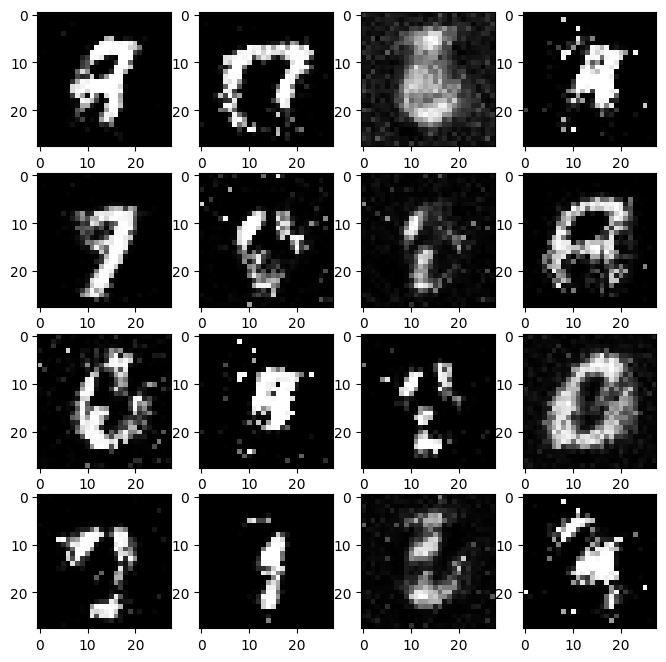

Epoch 14/20 (65.0%): [0/60032] (0.0%) D Error: 0.9558 G Error: 2.0962


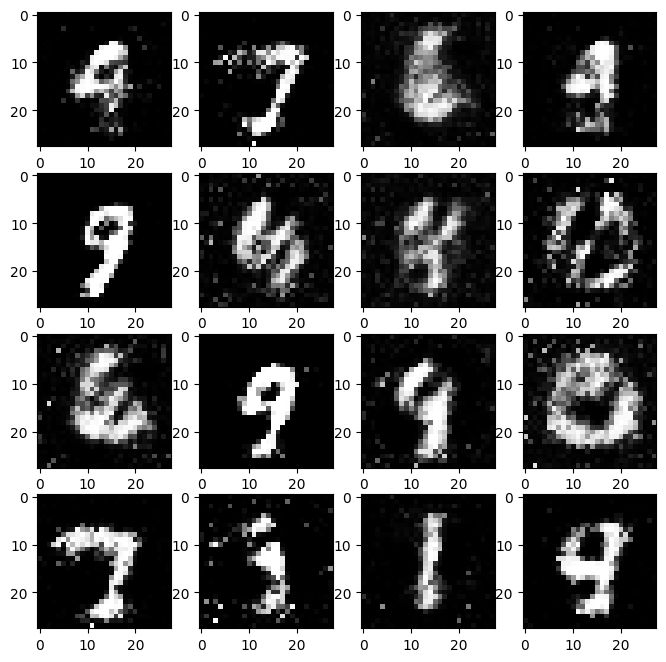

Epoch 15/20 (70.0%): [0/60032] (0.0%) D Error: 0.9791 G Error: 1.7313


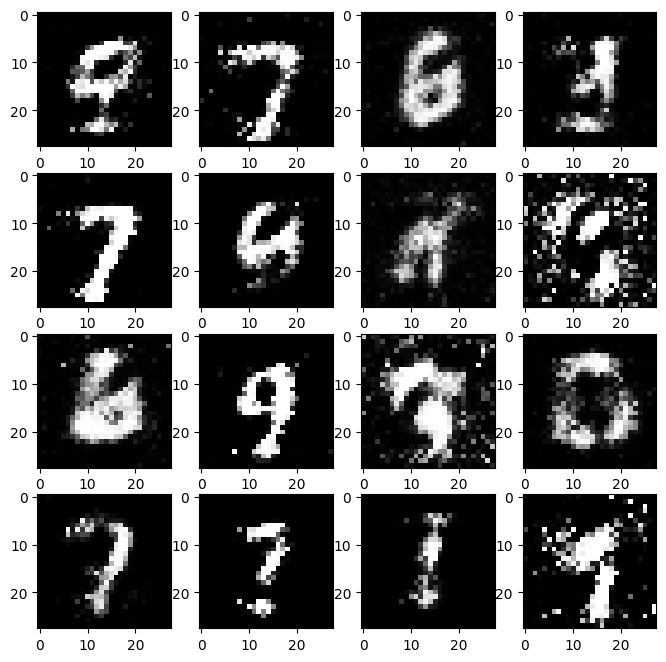

Epoch 16/20 (75.0%): [0/60032] (0.0%) D Error: 0.9114 G Error: 1.4436


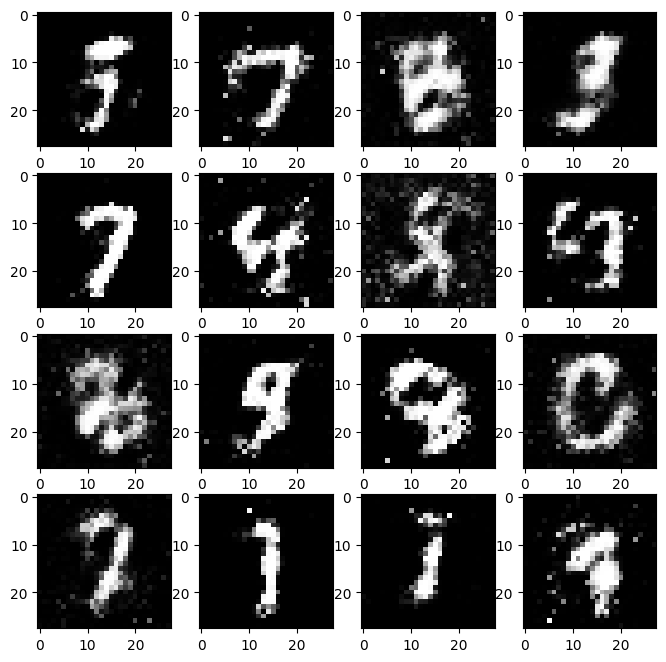

Epoch 17/20 (80.0%): [0/60032] (0.0%) D Error: 0.8857 G Error: 1.3456


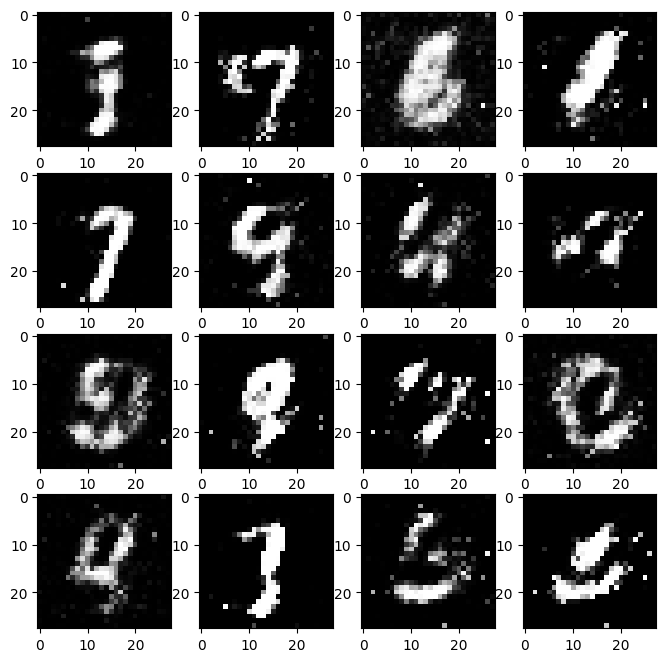

Epoch 18/20 (85.0%): [0/60032] (0.0%) D Error: 0.7849 G Error: 1.6199


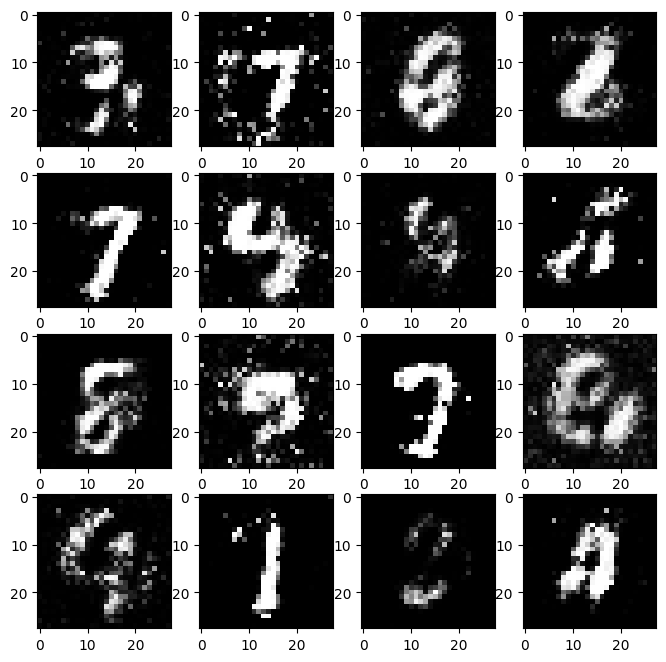

Epoch 19/20 (90.0%): [0/60032] (0.0%) D Error: 0.5502 G Error: 1.8071


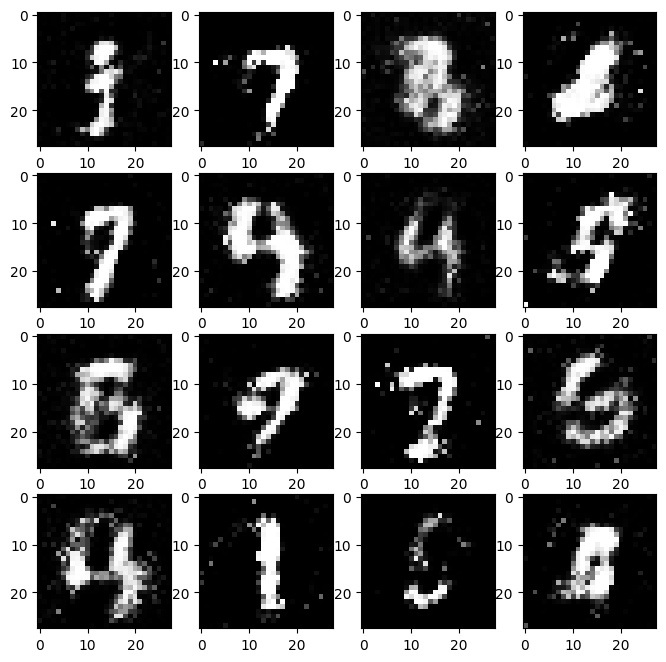

Epoch 20/20 (95.0%): [0/60032] (0.0%) D Error: 0.9060 G Error: 2.2842


In [17]:
for epoch in range(EPOCHS):
    for batch_idx, (batch, _) in enumerate(data_loader):
        # === Train D ===
        real_data = Variable(imgs_to_vec(batch))
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake, = train_discriminator(
            discriminator, d_optimizer, loss, real_data, fake_data)
        # === Train G ===
        fake_data = generator(noise(real_data.size(0)))
        g_error = train_generator(
            discriminator, g_optimizer, loss, fake_data)
        # === Logging ===
        #log(d_error, g_error, epoch, batch_idx, len(data_loader))

        if (batch_idx % DISPLAY_EVERY) == 0:
            test_images = vec_to_imgs(generator(test_noise)).data.cpu()
            display_images(test_images)
            # Logging
            display_logs(epoch, EPOCHS, batch_idx, NUM_BATCHES,
                         d_error, g_error, d_pred_real, d_pred_fake)